In [1]:
!pip uninstall datasets huggingface_hub fsspec -y
!pip install --upgrade pip setuptools wheel
!pip install datasets==2.18.0 huggingface_hub==0.20.3 fsspec==2023.10.0




Found existing installation: datasets 2.18.0
Uninstalling datasets-2.18.0:
  Successfully uninstalled datasets-2.18.0
Found existing installation: huggingface-hub 0.20.3
Uninstalling huggingface-hub-0.20.3:
  Successfully uninstalled huggingface-hub-0.20.3
Found existing installation: fsspec 2023.10.0
Uninstalling fsspec-2023.10.0:
  Successfully uninstalled fsspec-2023.10.0
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached datasets-2.18.0-py3-none-any.whl.metadata (20 kB)
  Using cached huggingface_hub-0.20.3-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2023.10.0-py3-none-any.whl.metadata (6.8 kB)
Using cached datasets-2.18.0-py3-none-any.whl (510 kB)
Using cached huggingface_hub-0.20.3-py3-none-any.whl (330 kB)
Using cached fsspec-2023.10.0-py3-none-any.whl (166 kB)


In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from datasets import load_dataset
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import sqrtm


/users/eleves-b/2022/elias.ben-rhouma/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def make_weight_list(samples=16, epochs=100):
    weights_samples_1 = []
    weights_samples_2 = []
    weights_samples_fc = []

    for _ in tqdm(range(samples)):
        # Step 1: Load the TREC dataset
        dataset = load_dataset("trec", split="train")
        dataset = dataset.train_test_split(test_size=0.2)
        train_data = dataset['train']
        val_data = dataset['test']

        # Step 2: Preprocess the data with a tokenizer
        tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        def preprocess(data):
            return tokenizer(data['text'], truncation=True, padding=True, max_length=32)

        train_data = train_data.map(preprocess, batched=True)
        val_data = val_data.map(preprocess, batched=True)

        train_data = train_data.rename_column("coarse_label", "label")
        val_data = val_data.rename_column("coarse_label", "label")

        train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
        val_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

        # Step 3: Create DataLoaders
        def collate_fn(batch):
            # Ensure all input tensors have the same length by padding them dynamically
            input_ids = torch.nn.utils.rnn.pad_sequence([b['input_ids'] for b in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
            attention_mask = torch.nn.utils.rnn.pad_sequence([b['attention_mask'] for b in batch], batch_first=True, padding_value=0)
            labels = torch.tensor([b['label'] for b in batch])
            return {"input_ids": input_ids, "attention_mask": attention_mask, "label": labels}

        train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_data, batch_size=16, collate_fn=collate_fn)

        # Step 4: Define a custom PyTorch model
        class CustomClassifier(nn.Module):
            def __init__(self, input_dim, hidden_dim, num_classes, num_attention_layers=2, vocab_size=30522):
                super(CustomClassifier, self).__init__()
                
                # Embedding layer to map token IDs to embeddings
                self.embedding = nn.Embedding(vocab_size, input_dim)  # vocab_size is typically 30522 for BERT
                
                # Define a list to store multiple attention layers
                self.attention_layers = nn.ModuleList([nn.Linear(input_dim, hidden_dim) for _ in range(num_attention_layers)])
                
                # Initialise the norm of the attention layers small enough
                for layer in self.attention_layers:
                    nn.init.normal_(layer.weight, mean=0, std=1e-1)
                    nn.init.constant_(layer.bias, 0)

                # Final fully connected layer for classification
                self.fc = nn.Linear(input_dim, num_classes)

            def _attention_layer(self, x, layer):
                # Project the input using the hidden layer
                x_new = self.attention_layers[layer](x)

                # Self attention (scaled dot-product)
                attention_scores = torch.matmul(x_new, x_new.transpose(1, 2)) / x_new.size(-1) ** 0.5  # Scaled attention scores
                attention_weights = torch.nn.functional.softmax(attention_scores, dim=-1)

                # Apply attention weights to each input in the batch
                x = torch.einsum("nij,njd->nid", attention_weights, x)
                return x

            def forward(self, input_ids, attention_mask):
                # Get the embeddings from the input IDs
                embedded = self.embedding(input_ids)
                
                # Apply attention layers
                for layer in range(len(self.attention_layers)):
                    embedded = self._attention_layer(embedded, layer)
                
                # Mean pooling (average the token embeddings across the sequence)
                pooled_output = embedded.mean(dim=1)  # Average over the token dimension
                
                # Pass through the final fully connected layer
                logits = self.fc(pooled_output)
                return logits

        model = CustomClassifier(input_dim=128, hidden_dim=256, num_classes=6)


        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Step 5: Define optimizer and loss function
        optimizer = AdamW(model.parameters(), lr=5e-5)
        criterion = torch.nn.CrossEntropyLoss()

        weights_attention_1 = []
        weights_attention_2 = []
        weights_fc = [] 


        # Step 6: Train the model
        def train(epoch):
            model.train()
            for batch in train_loader:
                optimizer.zero_grad()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                logits = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

                weights_attention_1.append(model.attention_layers[0].weight.data.cpu().numpy())
                weights_attention_2.append(model.attention_layers[1].weight.data.cpu().numpy())
                weights_fc.append(model.fc.weight.data.cpu().numpy())


            print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

        # Step 7: Evaluate the model
        def evaluate():
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    logits = model(input_ids=input_ids, attention_mask=attention_mask)
                    predictions = torch.argmax(logits, dim=-1)
                    correct += (predictions == labels).sum().item()
                    total += labels.size(0)

            print(f"Validation Accuracy: {correct / total:.4f}")

        # Run training and evaluation
        for epoch in range(epochs):
            train(epoch)
            evaluate()

        weights_samples_1.append(weights_attention_1)
        weights_samples_2.append(weights_attention_2)
        weights_samples_fc.append(weights_fc)

    return weights_samples_1, weights_samples_2, weights_samples_fc




def make_distance_measure(weights_attention_1, weights_attention_2, weights_fc):

    dist_1 = np.zeros(len(weights_attention_1))
    dist_2 = np.zeros(len(weights_attention_1))
    dist_3 = np.zeros(len(weights_fc))

    norm_1 = np.zeros((weights_attention_1[0].shape[0], weights_attention_1[0].shape[0]))
    norm_2 = np.zeros_like(norm_1)
    mag_1 = np.zeros_like(norm_1)
    mag_2 = np.zeros_like(norm_1)

    norm_1_final = np.linalg.norm(weights_attention_1[-1], axis=1)
    norm_2_final = np.linalg.norm(weights_attention_2[-1], axis=1)


    ### THIS USES SQUARED WEIGHTS
    weights_attention_1_squared = []
    weights_attention_2_squared = []
    weights_fc_squared = []

    for i in tqdm(range(len(weights_attention_1))):
        weights_attention_1_squared.append(np.einsum("pi,qi->pq", weights_attention_1[i],weights_attention_1[i]))
        weights_attention_2_squared.append(np.einsum("pi,qi->pq", weights_attention_2[i],weights_attention_2[i]))
        weights_fc_squared.append(np.einsum("pi,qi->pq", weights_fc[i], weights_fc[i]))


    norm_1_final = np.linalg.norm(weights_attention_1_squared[-1], ord="fro")
    norm_2_final = np.linalg.norm(weights_attention_2_squared[-1], ord="fro")
    norm_3_final = np.linalg.norm(weights_fc_squared[-1], ord="fro")      
    

    for i in tqdm(range(len(weights_attention_1))):
        norm_1 = np.linalg.norm(weights_attention_1_squared[i], ord="fro")
        norm_2 = np.linalg.norm(weights_attention_2_squared[i], ord="fro")
        norm_3 = np.linalg.norm(weights_fc_squared[i], ord="fro")

        mag_1 = np.einsum("pq,qk->pk", weights_attention_1_squared[i],weights_attention_1_squared[-1])
        mag_2 = np.einsum("pq,qk->pk", weights_attention_2_squared[i],weights_attention_2_squared[-1])
        mag_3 = np.einsum("pq,qk->pk", weights_fc_squared[i], weights_fc_squared[-1])

        dist_1[i] = np.trace(mag_1)/norm_1_final/norm_1
        dist_2[i] = np.trace(mag_2)/norm_2_final/norm_2
        dist_3[i] = np.trace(mag_3) / norm_3_final / norm_3

    return dist_1, dist_2, dist_3


In [ ]:
samples = 10
epochs = 100

# Ajout : récupération de weights_fc
weights_samples_1, weights_samples_2, weights_samples_fc = make_weight_list(samples, epochs)

# Initialisation des tableaux de distance
T = len(weights_samples_1[0])  # nombre d'epochs (ou itérations de suivi)
dist_samples_1 = np.zeros((samples, T))
dist_samples_2 = np.zeros((samples, T))
dist_samples_fc = np.zeros((samples, T))

# Calcul des similarités pour chaque run
for i in tqdm(range(samples)):
    dist_samples_1[i], dist_samples_2[i], dist_samples_fc[i] = make_distance_measure(
        weights_samples_1[i],
        weights_samples_2[i],
        weights_samples_fc[i]
    )


  0%|          | 0/10 [00:00<?, ?it/s]/users/eleves-b/2022/elias.ben-rhouma/.local/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for trec contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/trec
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Map: 100%|██████████| 1091/1091 [00:00<00:00, 28825.29 examples/s]
/users/eleves-b/2022/elias.ben-rhouma/.local/lib/python3.9/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 0: Loss = 1.6772
Validation Accuracy: 0.2071
Epoch 1: Loss = 1.6819
Validation Accuracy: 0.2566
Epoch 2: Loss = 1.7373
Validation Accuracy: 0.2521
Epoch 3: Loss = 1.6112
Validation Accuracy: 0.2686
Epoch 4: Loss = 1.6459
Validation Accuracy: 0.2731
Epoch 5: Loss = 1.6588
Validation Accuracy: 0.2933
Epoch 6: Loss = 1.5195
Validation Accuracy: 0.2997
Epoch 7: Loss = 1.8843
Validation Accuracy: 0.3236
Epoch 8: Loss = 1.5732
Validation Accuracy: 0.3437
Epoch 9: Loss = 1.6211
Validation Accuracy: 0.3327
Epoch 10: Loss = 1.5665
Validation Accuracy: 0.3556
Epoch 11: Loss = 1.9667
Validation Accuracy: 0.3602
Epoch 12: Loss = 1.6425
Validation Accuracy: 0.3721
Epoch 13: Loss = 1.6403
Validation Accuracy: 0.3758
Epoch 14: Loss = 1.5348
Validation Accuracy: 0.3923
Epoch 15: Loss = 1.5545
Validation Accuracy: 0.4079
Epoch 16: Loss = 1.4879
Validation Accuracy: 0.4005
Epoch 17: Loss = 1.5739
Validation Accuracy: 0.4253
Epoch 18: Loss = 1.5018
Validation Accuracy: 0.4335
Epoch 19: Loss = 1.484

 10%|█         | 1/10 [01:23<12:32, 83.56s/it]

Epoch 99: Loss = 0.4202
Validation Accuracy: 0.6572


Map: 100%|██████████| 1091/1091 [00:00<00:00, 28061.48 examples/s]


Epoch 0: Loss = 1.6440
Validation Accuracy: 0.2154
Epoch 1: Loss = 1.6677
Validation Accuracy: 0.2566
Epoch 2: Loss = 1.5736
Validation Accuracy: 0.2594
Epoch 3: Loss = 1.5589
Validation Accuracy: 0.2750
Epoch 4: Loss = 1.5658
Validation Accuracy: 0.2942
Epoch 5: Loss = 1.6371
Validation Accuracy: 0.3098
Epoch 6: Loss = 1.5794
Validation Accuracy: 0.2869
Epoch 7: Loss = 1.5414
Validation Accuracy: 0.3171
Epoch 8: Loss = 1.6746
Validation Accuracy: 0.3391
Epoch 9: Loss = 1.5968
Validation Accuracy: 0.3520
Epoch 10: Loss = 1.5172
Validation Accuracy: 0.3630
Epoch 11: Loss = 1.6937
Validation Accuracy: 0.3666
Epoch 12: Loss = 1.6035
Validation Accuracy: 0.3776
Epoch 13: Loss = 1.5244
Validation Accuracy: 0.3731
Epoch 14: Loss = 1.5537
Validation Accuracy: 0.3813
Epoch 15: Loss = 1.6012
Validation Accuracy: 0.3886
Epoch 16: Loss = 1.5871
Validation Accuracy: 0.4015
Epoch 17: Loss = 1.8094
Validation Accuracy: 0.4015
Epoch 18: Loss = 1.9654
Validation Accuracy: 0.3987
Epoch 19: Loss = 1.528

 20%|██        | 2/10 [02:47<11:08, 83.59s/it]

Epoch 99: Loss = 0.4291
Validation Accuracy: 0.6737


Map: 100%|██████████| 1091/1091 [00:00<00:00, 28523.25 examples/s]


Epoch 0: Loss = 1.6462
Validation Accuracy: 0.2282
Epoch 1: Loss = 1.6651
Validation Accuracy: 0.2383
Epoch 2: Loss = 1.5424
Validation Accuracy: 0.2566
Epoch 3: Loss = 1.7006
Validation Accuracy: 0.2686
Epoch 4: Loss = 1.6157
Validation Accuracy: 0.2896
Epoch 5: Loss = 1.5382
Validation Accuracy: 0.3052
Epoch 6: Loss = 1.5497
Validation Accuracy: 0.3025
Epoch 7: Loss = 1.4914
Validation Accuracy: 0.3153
Epoch 8: Loss = 1.5756
Validation Accuracy: 0.3318
Epoch 9: Loss = 1.6378
Validation Accuracy: 0.3520
Epoch 10: Loss = 1.5905
Validation Accuracy: 0.3630
Epoch 11: Loss = 1.5849
Validation Accuracy: 0.3529
Epoch 12: Loss = 1.4785
Validation Accuracy: 0.3822
Epoch 13: Loss = 1.4998
Validation Accuracy: 0.3822
Epoch 14: Loss = 1.5334
Validation Accuracy: 0.3923
Epoch 15: Loss = 1.4951
Validation Accuracy: 0.4060
Epoch 16: Loss = 1.6094
Validation Accuracy: 0.4051
Epoch 17: Loss = 1.4713
Validation Accuracy: 0.4180
Epoch 18: Loss = 1.6845
Validation Accuracy: 0.4381
Epoch 19: Loss = 1.566

 30%|███       | 3/10 [04:11<09:48, 84.12s/it]

Epoch 99: Loss = 0.6836
Validation Accuracy: 0.6544


Map: 100%|██████████| 1091/1091 [00:00<00:00, 29352.81 examples/s]


Epoch 0: Loss = 1.7208
Validation Accuracy: 0.2163
Epoch 1: Loss = 1.6855
Validation Accuracy: 0.2392
Epoch 2: Loss = 1.6839
Validation Accuracy: 0.2411
Epoch 3: Loss = 1.6504
Validation Accuracy: 0.2383
Epoch 4: Loss = 1.6931
Validation Accuracy: 0.2676
Epoch 5: Loss = 1.6630
Validation Accuracy: 0.2896
Epoch 6: Loss = 1.5480
Validation Accuracy: 0.3089
Epoch 7: Loss = 1.7233
Validation Accuracy: 0.3236
Epoch 8: Loss = 1.5959
Validation Accuracy: 0.3199
Epoch 9: Loss = 1.6136
Validation Accuracy: 0.3566
Epoch 10: Loss = 1.5561
Validation Accuracy: 0.3776
Epoch 11: Loss = 1.5232
Validation Accuracy: 0.3721
Epoch 12: Loss = 1.8174
Validation Accuracy: 0.3758
Epoch 13: Loss = 1.5397
Validation Accuracy: 0.3896
Epoch 14: Loss = 1.5687
Validation Accuracy: 0.4143
Epoch 15: Loss = 1.5335
Validation Accuracy: 0.4271
Epoch 16: Loss = 1.5324
Validation Accuracy: 0.4115
Epoch 17: Loss = 1.5080
Validation Accuracy: 0.4262
Epoch 18: Loss = 1.4888
Validation Accuracy: 0.4427
Epoch 19: Loss = 1.513

 40%|████      | 4/10 [05:35<08:23, 83.84s/it]

Epoch 99: Loss = 0.5946
Validation Accuracy: 0.6829


Map: 100%|██████████| 1091/1091 [00:00<00:00, 29766.96 examples/s]


Epoch 0: Loss = 1.7798
Validation Accuracy: 0.2566
Epoch 1: Loss = 1.7751
Validation Accuracy: 0.2484
Epoch 2: Loss = 1.6987
Validation Accuracy: 0.2566
Epoch 3: Loss = 1.5562
Validation Accuracy: 0.2456
Epoch 4: Loss = 1.5523
Validation Accuracy: 0.2851
Epoch 5: Loss = 1.8701
Validation Accuracy: 0.2786
Epoch 6: Loss = 1.6650
Validation Accuracy: 0.2887
Epoch 7: Loss = 1.5308
Validation Accuracy: 0.3016
Epoch 8: Loss = 1.7828
Validation Accuracy: 0.3199
Epoch 9: Loss = 1.5399
Validation Accuracy: 0.3355
Epoch 10: Loss = 1.5450
Validation Accuracy: 0.3428
Epoch 11: Loss = 1.5655
Validation Accuracy: 0.3355
Epoch 12: Loss = 1.5472
Validation Accuracy: 0.3547
Epoch 13: Loss = 1.5129
Validation Accuracy: 0.3831
Epoch 14: Loss = 1.6129
Validation Accuracy: 0.3740
Epoch 15: Loss = 1.5061
Validation Accuracy: 0.3721
Epoch 16: Loss = 1.8813
Validation Accuracy: 0.3896
Epoch 17: Loss = 1.5363
Validation Accuracy: 0.3941
Epoch 18: Loss = 1.5486
Validation Accuracy: 0.4161
Epoch 19: Loss = 1.547

 50%|█████     | 5/10 [06:56<06:53, 82.76s/it]

Epoch 99: Loss = 0.6495
Validation Accuracy: 0.6389


Map: 100%|██████████| 1091/1091 [00:00<00:00, 28855.10 examples/s]


Epoch 0: Loss = 1.7816
Validation Accuracy: 0.2264
Epoch 1: Loss = 1.6733
Validation Accuracy: 0.2126
Epoch 2: Loss = 1.6025
Validation Accuracy: 0.2282
Epoch 3: Loss = 1.6534
Validation Accuracy: 0.2530
Epoch 4: Loss = 1.6500
Validation Accuracy: 0.2658
Epoch 5: Loss = 1.5728
Validation Accuracy: 0.2832
Epoch 6: Loss = 1.6828
Validation Accuracy: 0.2970
Epoch 7: Loss = 1.5721
Validation Accuracy: 0.2961
Epoch 8: Loss = 1.6565
Validation Accuracy: 0.3226
Epoch 9: Loss = 1.5283
Validation Accuracy: 0.3556
Epoch 10: Loss = 1.6148
Validation Accuracy: 0.3740
Epoch 11: Loss = 1.5240
Validation Accuracy: 0.3822
Epoch 12: Loss = 1.4804
Validation Accuracy: 0.3914
Epoch 13: Loss = 1.4978
Validation Accuracy: 0.4042
Epoch 14: Loss = 1.4497
Validation Accuracy: 0.4088
Epoch 15: Loss = 1.4074
Validation Accuracy: 0.4290
Epoch 16: Loss = 1.4482
Validation Accuracy: 0.4280
Epoch 17: Loss = 1.5286
Validation Accuracy: 0.4510
Epoch 18: Loss = 1.3442
Validation Accuracy: 0.4638
Epoch 19: Loss = 1.524

 60%|██████    | 6/10 [08:25<05:39, 84.83s/it]

Epoch 99: Loss = 0.4530
Validation Accuracy: 0.6957


Map: 100%|██████████| 1091/1091 [00:00<00:00, 29349.04 examples/s]


Epoch 0: Loss = 1.7808
Validation Accuracy: 0.2383
Epoch 1: Loss = 1.6182
Validation Accuracy: 0.2667
Epoch 2: Loss = 1.5573
Validation Accuracy: 0.2704
Epoch 3: Loss = 1.8024
Validation Accuracy: 0.3153
Epoch 4: Loss = 1.5995
Validation Accuracy: 0.3364
Epoch 5: Loss = 1.5570
Validation Accuracy: 0.3382
Epoch 6: Loss = 1.5541
Validation Accuracy: 0.3199
Epoch 7: Loss = 1.5292
Validation Accuracy: 0.3721
Epoch 8: Loss = 1.5618
Validation Accuracy: 0.3905
Epoch 9: Loss = 1.5429
Validation Accuracy: 0.3978
Epoch 10: Loss = 1.8522
Validation Accuracy: 0.3813
Epoch 11: Loss = 1.5930
Validation Accuracy: 0.3786
Epoch 12: Loss = 1.5615
Validation Accuracy: 0.3822
Epoch 13: Loss = 1.5585
Validation Accuracy: 0.3932
Epoch 14: Loss = 1.4798
Validation Accuracy: 0.3996
Epoch 15: Loss = 1.5634
Validation Accuracy: 0.4051
Epoch 16: Loss = 1.5605
Validation Accuracy: 0.4143
Epoch 17: Loss = 1.5747
Validation Accuracy: 0.4244
Epoch 18: Loss = 1.5401
Validation Accuracy: 0.4244
Epoch 19: Loss = 1.517

 70%|███████   | 7/10 [09:48<04:13, 84.36s/it]

Epoch 99: Loss = 0.7923
Validation Accuracy: 0.7030


Map: 100%|██████████| 1091/1091 [00:00<00:00, 29399.96 examples/s]


Epoch 0: Loss = 1.7049
Validation Accuracy: 0.2090
Epoch 1: Loss = 1.6896
Validation Accuracy: 0.2383
Epoch 2: Loss = 1.6345
Validation Accuracy: 0.2502
Epoch 3: Loss = 1.7098
Validation Accuracy: 0.2649
Epoch 4: Loss = 1.9563
Validation Accuracy: 0.2557
Epoch 5: Loss = 1.6184
Validation Accuracy: 0.2750
Epoch 6: Loss = 1.5892
Validation Accuracy: 0.2640
Epoch 7: Loss = 1.5716
Validation Accuracy: 0.2896
Epoch 8: Loss = 1.5814
Validation Accuracy: 0.2942
Epoch 9: Loss = 1.5283
Validation Accuracy: 0.2915
Epoch 10: Loss = 1.6124
Validation Accuracy: 0.3135
Epoch 11: Loss = 1.4637
Validation Accuracy: 0.3190
Epoch 12: Loss = 1.5113
Validation Accuracy: 0.3208
Epoch 13: Loss = 1.4767
Validation Accuracy: 0.3025
Epoch 14: Loss = 1.5541
Validation Accuracy: 0.3346
Epoch 15: Loss = 1.9166
Validation Accuracy: 0.3382
Epoch 16: Loss = 1.5692
Validation Accuracy: 0.3428
Epoch 17: Loss = 1.4523
Validation Accuracy: 0.3465
Epoch 18: Loss = 1.4688
Validation Accuracy: 0.3456
Epoch 19: Loss = 1.600

 80%|████████  | 8/10 [11:16<02:50, 85.45s/it]

Epoch 99: Loss = 1.1157
Validation Accuracy: 0.6224


Map: 100%|██████████| 1091/1091 [00:00<00:00, 29230.37 examples/s]


Epoch 0: Loss = 1.7374
Validation Accuracy: 0.1971
Epoch 1: Loss = 1.6858
Validation Accuracy: 0.2851
Epoch 2: Loss = 1.7075
Validation Accuracy: 0.2933
Epoch 3: Loss = 1.6922
Validation Accuracy: 0.2823
Epoch 4: Loss = 1.6852
Validation Accuracy: 0.2988
Epoch 5: Loss = 1.7002
Validation Accuracy: 0.3071
Epoch 6: Loss = 1.5793
Validation Accuracy: 0.3217
Epoch 7: Loss = 1.5785
Validation Accuracy: 0.3327
Epoch 8: Loss = 1.6345
Validation Accuracy: 0.3318
Epoch 9: Loss = 1.8887
Validation Accuracy: 0.3566
Epoch 10: Loss = 1.8886
Validation Accuracy: 0.3877
Epoch 11: Loss = 1.5569
Validation Accuracy: 0.4060
Epoch 12: Loss = 1.4291
Validation Accuracy: 0.4070
Epoch 13: Loss = 1.4756
Validation Accuracy: 0.4198
Epoch 14: Loss = 1.4925
Validation Accuracy: 0.4290
Epoch 15: Loss = 1.5060
Validation Accuracy: 0.4565
Epoch 16: Loss = 1.4182
Validation Accuracy: 0.4638
Epoch 17: Loss = 1.5374
Validation Accuracy: 0.4730
Epoch 18: Loss = 1.3954
Validation Accuracy: 0.4757
Epoch 19: Loss = 1.604

 90%|█████████ | 9/10 [12:39<01:24, 84.86s/it]

Epoch 99: Loss = 1.0366
Validation Accuracy: 0.6572


Map: 100%|██████████| 1091/1091 [00:00<00:00, 28761.51 examples/s]


Epoch 0: Loss = 1.7043
Validation Accuracy: 0.2172
Epoch 1: Loss = 1.6582
Validation Accuracy: 0.2383
Epoch 2: Loss = 1.5740
Validation Accuracy: 0.2475
Epoch 3: Loss = 1.5948
Validation Accuracy: 0.2612
Epoch 4: Loss = 1.6615
Validation Accuracy: 0.2658
Epoch 5: Loss = 1.6161
Validation Accuracy: 0.2896
Epoch 6: Loss = 1.5994
Validation Accuracy: 0.2988
Epoch 7: Loss = 1.5307
Validation Accuracy: 0.3153
Epoch 8: Loss = 1.7370
Validation Accuracy: 0.3272
Epoch 9: Loss = 1.5476
Validation Accuracy: 0.3291
Epoch 10: Loss = 1.5414
Validation Accuracy: 0.3538
Epoch 11: Loss = 1.5868
Validation Accuracy: 0.3639
Epoch 12: Loss = 1.5491
Validation Accuracy: 0.3529
Epoch 13: Loss = 1.5368
Validation Accuracy: 0.3621
Epoch 14: Loss = 1.4726
Validation Accuracy: 0.3483
Epoch 15: Loss = 1.8771
Validation Accuracy: 0.3547
Epoch 16: Loss = 1.4814
Validation Accuracy: 0.3877
Epoch 17: Loss = 1.4972
Validation Accuracy: 0.3841
Epoch 18: Loss = 1.5134
Validation Accuracy: 0.3941
Epoch 19: Loss = 1.511

In [15]:
np.save("realistic_dist_samples_1.npy", dist_samples_1)
np.save("realistic_dist_samples_2.npy", dist_samples_2)
np.save("realistic_dist_samples_fc.npy", dist_samples_fc)


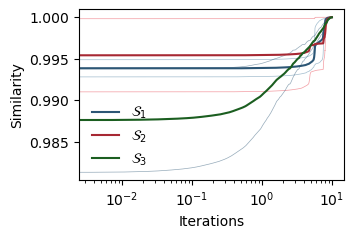

In [16]:
colors = ["#457B9D", "#E63946", "#2C5675", "#A72833","#1B5E20"]
plt.figure(figsize=(3.416, 2.216))

dist_samples_1 = np.load("realistic_dist_samples_1.npy")
dist_samples_2 = np.load("realistic_dist_samples_2.npy")
dist_samples_fc = np.load("realistic_dist_samples_fc.npy")

abs = np.linspace(0, epochs, dist_samples_1.shape[1])


plt.plot(abs, dist_samples_1.T, color=colors[0], lw=0.5, alpha=0.5)
plt.plot(abs, dist_samples_2.T, color=colors[1], lw=0.5, alpha=0.5)
plt.plot(abs, dist_samples_fc.T, color=colors[2], lw=0.5, alpha=0.5)

plt.plot(abs, dist_samples_1.mean(axis=0), label=r"$\mathcal{S}_1$", color=colors[2])
plt.plot(abs, dist_samples_2.mean(axis=0), label=r"$\mathcal{S}_2$", color=colors[3])
plt.plot(abs, dist_samples_fc.mean(axis=0), label=r"$\mathcal{S}_3$", color=colors[4])

plt.legend(frameon=False)
plt.xlabel("Iterations")
plt.ylabel("Similarity")
plt.xscale('log')
plt.show()